In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from functions_geom_DIB import geom_DIB_on_alternatives

In [2]:
# Load data
data = pd.read_csv('../data/optima.dat', sep='\t')

# Remove missing values, i.e. choice = -1
data = data[data['Choice'] != -1]

In [3]:
# display every column of the dataframe
pd.set_option('display.max_columns', None)
data

,ID,DestAct,NbTransf,TimePT,WalkingTimePT,WaitingTimePT,CostPT,CostCar,TimeCar,NbHousehold,NbChild,NbCar,NbMoto,NbBicy,NbBicyChild,NbComp,NbTV,Internet,NewsPaperSubs,NbCellPhones,NbSmartPhone,HouseType,OwnHouse,NbRoomsHouse,YearsInHouse,Income,Gender,BirthYear,Mothertongue,FamilSitu,OccupStat,SocioProfCat,CalculatedIncome,Education,HalfFareST,LineRelST,GenAbST,AreaRelST,OtherST,CarAvail,MarginalCostPT,CostCarCHF,Envir01,Envir02,Envir03,Envir04,Envir05,Envir06,Mobil01,Mobil02,Mobil03,Mobil04,Mobil05,Mobil06,Mobil07,Mobil08,Mobil09,Mobil10,Mobil11,Mobil12,Mobil13,Mobil14,Mobil15,Mobil16,Mobil17,Mobil18,Mobil19,Mobil20,Mobil21,Mobil22,Mobil23,Mobil24,Mobil25,Mobil26,Mobil27,ResidCh01,ResidCh02,ResidCh03,ResidCh04,ResidCh05,ResidCh06,ResidCh07,LifSty01,LifSty02,LifSty03,LifSty04,LifSty05,LifSty06,LifSty07,LifSty08,LifSty09,LifSty10,LifSty11,LifSty12,LifSty13,LifSty14,TripPurpose,TypeCommune,UrbRur,LangCode,ClassifCodeLine,frequency,ResidChild,NbTrajects,FreqCarPar,FreqTrainPar,FreqOtherPar,FreqTripHouseh,Region,distance_km,Choice,InVehicleTime,ModeToSchool,ReportedDuration,CoderegionCAR,age,Weight
0,10350017,2,4,85,23,10,12.4,3.17,32,2,0,1,0,3,0,2,1,1,2,2,2,1,2,5.0,1,4,1,1983,2,2,3,3,7000,7,2,2,1,2,2,2,0.0,4.54,3,5,1,3,5,5,5,3,4,5,3,1,1,1,5,6,5,1,5,1,5,1,5,5,5,1,5,1,5,5,5,5,5,3,5,1,1,1,1,5,4,3,5,5,6,5,1,5,1,2,3,5,5,1,1,7,1,1,4,1,5,2,4,1,1,4,1,30.0,1,52,3,255,1,27,0.000379
2,10350025,11,2,82,33,5,3.0,0.45,6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,2,2,2,-1,3.0,0.64,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,3,7,1,1,4,1,-1,1,-1,-1,-1,2,1,4.5,0,44,-1,20,1,-1,0.000368
3,10350075,1,3,107,21,31,24.0,2.36,23,2,0,1,0,0,0,1,2,1,1,2,0,1,1,5.0,29,2,2,1947,2,2,2,4,3250,3,2,2,2,2,2,1,24.0,3.38,3,2,3,4,4,4,4,4,3,5,3,4,4,3,5,2,4,2,5,5,4,3,4,5,4,1,4,4,4,2,4,2,4,4,4,4,3,3,4,5,4,2,4,4,3,3,3,4,3,2,4,4,4,2,1,7,1,1,4,1,5,1,3,2,2,1,1,25.0,1,55,-1,30,1,63,0.000368
4,10350085,1,5,190,116,18,10.8,1.16,14,3,0,2,0,3,0,1,2,1,2,2,0,1,1,4.0,22,4,1,1953,2,3,1,6,7000,3,2,2,2,2,2,1,10.8,1.66,1,3,3,3,5,4,5,1,3,4,4,5,5,1,2,4,5,1,5,5,3,5,4,6,6,6,5,1,5,3,1,6,1,3,3,2,2,1,3,3,3,4,3,3,1,3,1,1,3,3,3,3,4,1,1,7,1,1,4,1,6,2,2,1,2,3,1,12.5,1,56,-1,20,1,57,0.000409
5,10350086,1,4,116,38,29,9.6,1.89,20,3,0,2,0,3,0,1,2,1,2,3,0,1,1,4.0,22,4,2,1952,2,3,4,6,7000,3,2,2,2,2,2,2,9.6,2.71,2,4,3,2,5,4,4,2,3,4,3,5,2,1,3,3,5,2,5,4,3,5,3,3,3,2,4,1,2,2,2,2,2,3,3,4,2,1,2,5,4,4,4,3,1,2,2,4,3,4,2,2,1,2,1,7,1,1,4,1,5,2,1,2,2,3,1,19.0,1,49,-1,30,1,58,0.000368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,96040531,1,4,148,28,69,10.4,3.92,40,5,2,1,1,4,2,1,1,1,1,2,0,1,2,7.0,16,2,2,1973,1,3,2,8,3250,3,2,2,2,2,2,1,10.4,5.62,3,4,4,3,3,3,3,3,3,3,3,5,5,3,4,4,4,4,5,5,3,3,3,3,3,3,4,4,4,4,3,3,3,4,3,3,3,3,3,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,8,1,2,3,2,5,1,1,1,1,3,7,42.0,1,51,5,35,7,37,0.000870
2261,96040537,8,0,139,116,0,14.4,3.18,43,5,0,2,1,1,0,2,1,1,2,5,0,1,1,7.0,23,4,2,1964,1,3,1,3,7000,3,2,2,2,2,2,1,14.4,4.56,2,3,4,6,6,4,4,6,4,6,6,5,5,2,6,6,5,2,5,6,6,4,4,3,3,3,6,2,4,6,2,6,6,1,1,2,3,1,1,5,2,2,4,5,5,2,1,5,3,1,2,4,2,4,-1,8,1,2,3,2,6,4,4,1,1,3,7,32.0,1,23,5,70,7,46,0.000368
2262,96040537,8,0,71,57,0,6.0,0.94,12,5,0,2,1,1,0,2,1,1,2,5,0,1,1,7.0,23,4,2,1964,1,3,1,3,7000,3,2,2,2,2,2,1,6.0,1.35,2,3,4,6,6,4,4,6,4,6,6,5,5,2,6,6,5,2,5,6,6,4,4,3,3,3,6,2,4,6,2,6,6,1,1,2,3,1,1,5,2,2,4,5,5,2,1,5,3,1,2,4,2,4,3,8,1,2,3,2,6,2,4,1,1,3,7,9.0,1,14,5,20,7,46,0.000368
2263,96040538,11,2,118,70,10,11.4,1.77,24,5,0,2,1,1,0,2,1,1,2,5,0,1,1

In [4]:
data_used = data[['ID', 'TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF', 'ReportedDuration', 'Choice']]

In [5]:
data_used

,ID,TimePT,MarginalCostPT,TimeCar,CostCarCHF,ReportedDuration,Choice
0,10350017,85,0.0,32,4.54,255,1
2,10350025,82,3.0,6,0.64,20,0
3,10350075,107,24.0,23,3.38,30,1
4,10350085,190,10.8,14,1.66,20,1
5,10350086,116,9.6,20,2.71,30,1
...,...,...,...,...,...,...,...
2259,96040531,148,10.4,40,5.62,35,1
2261,96040537,139,14.4,43,4.56,70,1
2262,96040537,71,6.0,12,1.35,20,1
2263,96040538,118,11.4,24,2.54,30,1


In [6]:
# beta_names = ["ASC_private", "ASC_soft", "BETA_Time", "BETA_Cost", "lambda_PT_private"]


# Define log-likelihood function
def log_likelihood_optima_NLM(beta, data):
    # Define utility functions
    data['U_PT'] = beta[2] * data['TimePT'] + beta[3] * data['MarginalCostPT']
    data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
    data['U_soft'] = beta[1] + beta[2] * data['ReportedDuration']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_PT_private'] = np.log(np.exp(data['U_PT'] / beta[4]) + np.exp(data['U_private'] / beta[4]))
    
    # Nest probabilities
    data['P_nest_PT_private'] = np.exp(beta[4] * data['logsum_PT_private']) / \
                               (np.exp(beta[4] * data['logsum_PT_private']) + np.exp(data['U_soft']))
    data['P_nest_soft'] = 1 - data['P_nest_PT_private']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_PT_in_PT_private'] = (np.exp(data['U_PT'] / beta[4])) / \
                                  (np.exp(data['U_PT'] / beta[4]) + np.exp(data['U_private'] / beta[4]))
    data['P_private_in_PT_private'] = 1 - data['P_PT_in_PT_private']
    
    # Full probabilities
    data['P_PT_1'] = data['P_nest_PT_private'] * data['P_PT_in_PT_private']
    data['P_private_2'] = data['P_nest_PT_private'] * data['P_private_in_PT_private']
    data['P_soft_3'] = data['P_nest_soft']

    # Calculate probability for chosen alternative for each row
    data['P'] = (data['Choice'] == 0) * data['P_PT_1'] + \
                (data['Choice'] == 1) * data['P_private_2'] + \
                (data['Choice'] == 2) * data['P_soft_3']
    
    # Calculate log-likelihood
    LL = data.groupby('ID')['P'].prod().apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood


In [7]:
# Define model parameters
beta = np.array([0, 0, 0, 0, 1])
beta_names = ["ASC_private", "ASC_soft", "BETA_Time", "BETA_Cost", "lambda_PT_soft"]

# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data_used, beta, beta_names, log_likelihood_optima_NLM)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3323/3660123595.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_PT'] = beta[2] * data['TimePT'] + beta[3] * data['MarginalCostPT']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3323/3660123595.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3323/3660123595.py:9: SettingWithCopy

Optimization Results:
        Parameter  Estimate  Robust Asymptotic SE  t-statistic   p-value
0     ASC_private  0.000339              0.002732     0.124170  0.901194
1        ASC_soft -2.747595              0.096958   -28.337936  0.000000
2       BETA_Time -0.000006              0.000051    -0.125053  0.900495
3       BETA_Cost -0.000092              0.000759    -0.121358  0.903420
4  lambda_PT_soft  0.001217              0.009868     0.123315  0.901871
AIC: 2838.3189076588906
BIC: 2866.0827180799615
Log-likelihood: -1414.1594538294453


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3323/3660123595.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_PT'] = beta[2] * data['TimePT'] + beta[3] * data['MarginalCostPT']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3323/3660123595.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_private'] = beta[0] + beta[2] * data['TimeCar'] + beta[3] * data['CostCarCHF']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3323/3660123595.py:9: SettingWithCopy

In [8]:
df_input = data[['TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF', 'ReportedDuration']]
# Calculate frequencies and probabilities
vector_counts = df_input.value_counts().reset_index(name='Frequency')
vector_counts['Probability'] = vector_counts['Frequency'] / len(df_input)

# Creating a tuple of attributes to facilitate mapping
vector_counts['tuple'] = vector_counts[['TimePT', 'MarginalCostPT', 'TimeCar', 'CostCarCHF',
                                         'ReportedDuration']].apply(tuple, axis=1)
probability_map = vector_counts.set_index('tuple')['Probability'].to_dict()

# Assign the probability to each row based on its tuple of attributes
df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3323/1679802737.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


In [9]:
# Computation of p(x,y)
p_x = df_input['Probability'].values

p_y_given_x = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [10]:
def simulate_choice_optima(row):
    """
    Function to simulate a choice based on cumulative probabilities.

    Parameters:
    - row: pandas Series or DataFrame row containing probabilities for each choice

    Returns:
    - The simulated choice (an integer between 1 and the number of choices)
    """
    # Generate a random number between 0 and 1
    random_number = np.random.rand()
    
    # Calculate cumulative probabilities
    probabilities = row[['P_PT_1', 'P_private_2', 'P_soft_3']]
    cumulative_probs = probabilities.cumsum()
    
    # Determine simulated choice based on random number
    for i, cumulative_prob in enumerate(cumulative_probs):
        if random_number <= cumulative_prob:
            return i+1

In [11]:
np.random.seed(123)
data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)
data_used

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3323/2856924636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)


,ID,TimePT,MarginalCostPT,TimeCar,CostCarCHF,ReportedDuration,Choice,U_PT,U_private,U_soft,logsum_PT_private,P_nest_PT_private,P_nest_soft,P_PT_in_PT_private,P_private_in_PT_private,P_PT_1,P_private_2,P_soft_3,P,simulated_choice
0,10350017,85,0.0,32,4.54,255,1,-0.000541,-0.000283,-2.749219,0.360260,0.939894,0.060106,0.447016,0.552984,0.420147,0.519747,0.060106,0.519747,2
2,10350025,82,3.0,6,0.64,20,0,-0.000798,0.000242,-2.747722,0.553316,0.939823,0.060177,0.298348,0.701652,0.280394,0.659429,0.060177,0.280394,2
3,10350075,107,24.0,23,3.38,30,1,-0.002891,-0.000118,-2.747786,0.000222,0.939788,0.060212,0.092910,0.907090,0.087316,0.852473,0.060212,0.852473,2
4,10350085,190,10.8,14,1.66,20,1,-0.002205,0.000097,-2.747722,0.220439,0.939800,0.060200,0.131065,0.868935,0.123175,0.816624,0.060200,0.816624,2
5,10350086,116,9.6,20,2.71,30,1,-0.001623,-0.000038,-2.747786,0.209555,0.939803,0.060197,0.213727,0.786273,0.200861,0.738941,0.060197,0.738941,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,96040531,148,10.4,40,5.62,35,1,-0.001900,-0.000433,-2.747818,-0.093802,0.939784,0.060216,0.230450,0.769550,0.216573,0.723210,0.060216,0.723210,2
2261,96040537,139,14.4,43,4.56,70,1,-0.002211,-0.000354,-2.748041,-0.094498,0.939796,0.060204,0.178609,0.821391,0.167856,0.771940,0.060204,0.771940,2
2262,96040537,71,6.0,12,1.35,20,1,-0.001005,0.000139,-2.747722,0.443781,0.939815,0.060185,0.281009,0.718991,0.264097,0.675718,0.060185,0.675718,1
2263,96040538,118,11.4,24,2.54,30,1,-0.001801,-0.000047,-2.747786,0.173433,0.939800,0.060200,0.191362,0.808638,0.179842,0.759958,0.060200,0.759958,2


Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

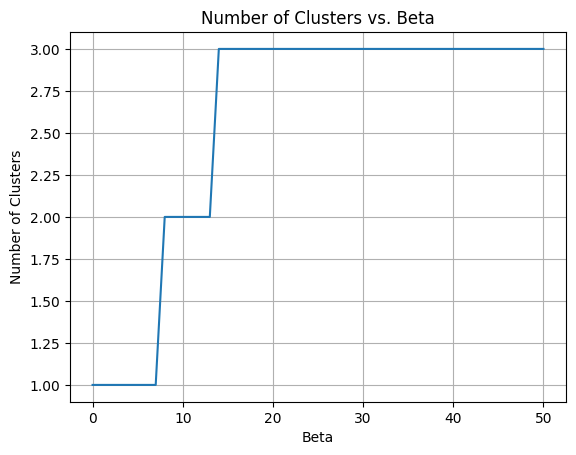

In [12]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [13]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=30, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000


In [14]:
import re

# Define a function to extract the number from the column name
def extract_number(column_name):
    match = re.search(r'\d+', column_name)  # Search for one or more digits in the column name
    if match:
        return int(match.group())  # Return the first occurrence of digits as an integer
    else:
        return None  # Return None if no digits are found

In [15]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data_used['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data_used.groupby(['cluster', 'Choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data_used['max_proba'] = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].idxmax(axis=1).apply(extract_number)
cluster_counts2 = data_used.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data_used.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
0    1578
2     278
1      50
Name: count, dtype: int64

 Choice     0     1    2
cluster                
0        462  1004  112
1         40     9    1
2         34   243    1

 max_proba   1     2
cluster            
0          56  1522
1          50     0
2           0   278

 simulated_choice    1    2   3
cluster                       
0                 482  998  98
1                  31   13   6
2                  25  236  17


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3323/2352194042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3323/2352194042.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['max_proba'] = data_used[['P_PT_1', 'P_private_2', 'P_soft_3']].idxmax(axis=1).apply(extract_number)
